In [18]:
using Lattices
using LinearAlgebra
using Combinatorics
using SparseArrays
using Plots
import Graphs
using LaTeXStrings
using Statistics
using Random
using Zygote
using Optimization, OptimizationOptimisers
using JSON
using OptimizationOptimJL
using ExponentialUtilities


include("ed_objects.jl")
include("ed_functions.jl")
include("ed_optimization.jl")
include("utility_Functions.jl")

append_to_json_files (generic function with 1 method)

# eigenstate comparison

In [3]:
# using KrylovKit

t = 1.0
U = 6
μ = 0  # positive incentivises fewer particles (one electron costs this much energy)
# N_up = 2
# N_down = 2
N = 4
half_filling = false
# lattice = Chain(6, Periodic())
lattice = Square((2,3), Periodic())
# lattice = Graphs.cycle_graph(3)

models = []

reference_index = 2
t_values = []# Float64[1,1], Float64[1,0.1], 1.0]
# for _t in t_values
#     # println(_t)
#     push!(models,HubbardModel(_t,0.0001,μ,half_filling))
# end
# U_values = [0.00001,0.01,0.2, 1,1.001,3,4,5,7,10, 100]
U_values = [0.00001; LinRange(2.1,9,20)]
for U in U_values
    # println(t)
    push!(models,HubbardModel(t,U,μ,half_filling))
end

subspace = HubbardSubspace(N, lattice)
# subspace = HubbardSubspace(N_up, N_down, lattice)

ops = []
push!(ops,Matrix(create_operator(subspace,:Sx)))
push!(ops, Matrix(create_operator(subspace,:S2)))
# op3 = Matrix(create_operator(subspace,:L2))
push!(ops, Matrix(create_operator(subspace,:T, kind=1)))
push!(ops, Matrix(create_operator(subspace,:T, kind=2)))
# push!(ops, Matrix(create_operator(subspace,:σ, kind=1)))
E = []
H = []
V = []
for model ∈ models
    push!(H, Matrix(create_Hubbard(model, subspace; perturbations=false)))
    e, v = eigen(H[end])
    push!(E, e)
    push!(V, v)
end

for i ∈ 1:2
    println(degeneracy_count(E[i]))
end

# println(sum(abs.(h1*h2-h2*h1)))
ops_tmp = [H[1], ops...]
for i in eachindex(ops_tmp)
    for j in i+1:length(ops_tmp)
        println("($i,$j) ", sum(abs.(ops_tmp[i]*ops_tmp[j] - ops_tmp[j]*ops_tmp[i])))
    end
end
# H1 = create_Hubbard(model, subspace; perturbations=false)
# E1 = diag(V1'*Matrix(H1)*V1)

degen_rm_U = create_consistent_basis(H, ops;reference_index=reference_index)

dim = get_subspace_dimension(subspace)
indexer = CombinationIndexer(reduce(vcat,collect(sites(subspace.lattice))), get_subspace_info(subspace)...)
difference_dict = collect_all_conf_differences(indexer)


Dict{Any, Any}(5 => 3, 20 => 3, 8 => 1, 22 => 1, 6 => 28, 11 => 2, 3 => 18, 7 => 1, 4 => 2, 2 => 27, 10 => 3, 27 => 1)
Dict{Any, Any}(5 => 3, 4 => 4, 6 => 34, 20 => 2, 2 => 34, 10 => 2, 9 => 1, 3 => 31)
(1,2) 0.0
(1,3) 0.0
(1,4) 0.0
(1,5) 0.0
(2,3) 0.0
(2,4) 0.0
(2,5) 0.0
(3,4) 0.0
(3,5) 0.0
(4,5) 0.0


Dict{Any, Any} with 4 entries:
  4 => Dict{Tuple{Tuple{Set{Coordinate{2, Int64}}, Set{Coordinate{2, Int64}}}, …
  2 => Dict{Tuple{Tuple{Set{Coordinate{2, Int64}}, Set{Coordinate{2, Int64}}}, …
  3 => Dict{Tuple{Tuple{Set{Coordinate{2, Int64}}, Set{Coordinate{2, Int64}}}, …
  1 => Dict{Tuple{Tuple{Set{Coordinate{2, Int64}}, Set{Coordinate{2, Int64}}}, …

In [98]:
U_values[5]

3.189473684210526

In [28]:
t_dict = Dict{Vector{Tuple{Coordinate{2,Int64},Int,Symbol}}, Float64}()
for σ in 1:2
    for s1 in indexer.a
        for s2 in neighbors(subspace.lattice,s1)
            if [(s1, σ,:create), (s2, σ, :annihilate)] ∉ keys(t_dict)
                t_dict[[(s1, σ,:create), (s2, σ, :annihilate)]] = 0.5*t
            else
                t_dict[[(s1, σ,:create), (s2, σ, :annihilate)]] += 0.5*t
            end
        end
    end
end
# for σ in 1:2
#     for s1 in indexer.a
#         if [(s1, σ,:create), (s1, σ, :annihilate)] ∉ keys(t_dict)
#             t_dict[[(s1, σ,:create), (s1, σ, :annihilate)]] = 100
#         else
#             t_dict[[(s1, σ,:create), (s1, σ, :annihilate)]] += 100
#         end
#     end
# end

for s1 in indexer.a
    if [(s1, 1,:create), (s1, 1, :annihilate),(s1, 2,:create),(s1, 2, :annihilate)] ∉ keys(t_dict)
        t_dict[[(s1, 1,:create), (s1, 1, :annihilate),(s1, 2,:create),(s1, 2, :annihilate)]] = 4
    else
        t_dict[[(s1, 1,:create), (s1, 1, :annihilate),(s1, 2,:create),(s1, 2, :annihilate)]] += 4
    end
end
rows = Int[]
cols = Int[]
vals = Float64[]
general_n_body!(rows, cols, vals, t_dict, indexer)
H2 = Matrix(sparse(rows, cols, vals))
eigvals(H2)
# H[1]


Float64


66-element Vector{Float64}:
 -6.00000000000001
 -6.0
 -6.0
 -5.6131750620735135
 -5.613175062073505
 -5.029182016525051
 -3.0
 -3.0
 -2.9999999999999996
 -2.9999999999999996
  ⋮
  4.999999999999998
  5.0
  5.0
  5.000000000000003
  5.0000000000000036
  5.999999999999994
  6.959974076962631
  6.959974076962632
  9.029182016525052

In [7]:
# state = degen_rm_U[1][:,1]
args = correlation_matrix(1, indexer)
for i in axes(V[1][:,1:100],2)
    state1 = degen_rm_U[1][:,i]
    state2 = degen_rm_U[7][:,i]
    energy = real.(diag(degen_rm_U[7]'*H[7]*degen_rm_U[7])[i])
    println("state #:$i U=1 energy: $(energy) \t U=0,!=0 SD?:$(is_slater_determinant(state1, indexer; correlation_args=args)) $(is_slater_determinant(state2, indexer; correlation_args=args))   \t overlap: $(real(degen_rm_U[1][:,i]'*degen_rm_U[11][:,i]))")
end
# γ = compute_correlation(state, 1, indexer)
# println("rank(γ)=$(rank(γ))  sum(γ^2 -γ)=$(sum(abs.(γ^2-γ)))")
# eigvals(Matrix(mats[4,4]))

state #:1 U=1 energy: -1.0000000000000018 	 U=0,!=0 SD?:false false   	 overlap: 1.0000000000000018
state #:2 U=1 energy: 2.000000000000004 	 U=0,!=0 SD?:false false   	 overlap: 1.000000000000002
state #:3 U=1 energy: -1.0000000000000018 	 U=0,!=0 SD?:false false   	 overlap: 1.000000000000002
state #:4 U=1 energy: 3.0000000000000044 	 U=0,!=0 SD?:false false   	 overlap: 1.0000000000000018
state #:5 U=1 energy: -5.000000000000007 	 U=0,!=0 SD?:false false   	 overlap: 1.0000000000000016
state #:6 U=1 energy: -1.0000000000000013 	 U=0,!=0 SD?:false false   	 overlap: 1.000000000000001
state #:7 U=1 energy: 2.000000000000003 	 U=0,!=0 SD?:false false   	 overlap: 1.0000000000000013
state #:8 U=1 energy: -1.0000000000000009 	 U=0,!=0 SD?:false false   	 overlap: 1.0000000000000009
state #:9 U=1 energy: -1.0000000000000007 	 U=0,!=0 SD?:false false   	 overlap: 1.0000000000000009
state #:10 U=1 energy: 2.0000000000000027 	 U=0,!=0 SD?:true true   	 overlap: 1.0000000000000004
state #:11 

In [13]:
args = correlation_matrix(1, indexer)
for i in 1:100
    if is_slater_determinant(degen_rm_U[11][:,i], indexer; correlation_args=args)
        println("$i $(real(degen_rm_U[1][:,i]'*degen_rm_U[11][:,i]))")
    else
        println("NOT $i: $(degen_rm_U[1][:,i]'*degen_rm_U[11][:,i])")
    end
end

NOT 1: 0.9999999999999998 + 0.0im
NOT 2: 0.9999999999999987 + 0.0im
NOT 3: 1.0 + 0.0im
NOT 4: 0.9999999999999993 + 0.0im
NOT 5: 0.9999999999999994 + 0.0im
NOT 6: 1.0 + 0.0im
NOT 7: 0.9999999999999996 + 0.0im
NOT 8: 0.6438664915392097 - 1.32237970573712e-13im
NOT 9: 0.5637713409769917 - 3.0878077872387166e-16im
NOT 10: 0.3627957487873087 + 1.3617579286417936e-15im
NOT 11: -0.17820874315096494 - 5.898059818321144e-15im
NOT 12: 0.2800641662921307 - 5.379724443699274e-14im
NOT 13: -0.0058034011820140416 - 0.0424350117979215im
NOT 14: 0.8628505821585994 + 0.023369540047823732im
NOT 15: 0.3313067383843887 - 0.007646846428694211im
NOT 16: 0.50014319533655 - 0.07989093983514839im
NOT 17: 0.3429921763531929 - 0.0072888326638767195im
NOT 18: 0.4233709210195571 - 0.05853550694975097im
NOT 19: 0.39000060183141216 + 0.00336820889430953im
NOT 20: 0.2482517636437967 - 4.8606951796870135e-15im
NOT 21: 0.5637713409769929 - 3.452099717193846e-16im
NOT 22: 0.8106405316729927 - 0.014924153225673087im
NOT 

In [129]:
# degen = count_degeneracies_per_subspace(H[3], ops)
indices_of_interest = []
for (indices, val) in degen
    (d, dim) = val
    if length(d) == 0
        # println(dim)
    else
        push!(indices_of_interest, indices)
        println("d: $d dim: $dim indices: $indices")
    end
end

d: Dict{Any, Any}(2 => 1) dim: 14 indices: [6, 1, 2, 1]
d: Dict{Any, Any}(2 => 1) dim: 14 indices: [6, 1, 1, 3]
d: Dict{Any, Any}(2 => 1) dim: 14 indices: [5, 3, 1, 2]
d: Dict{Any, Any}(2 => 1) dim: 14 indices: [6, 1, 2, 3]
d: Dict{Any, Any}(2 => 1) dim: 14 indices: [5, 3, 2, 2]
d: Dict{Any, Any}(2 => 1) dim: 14 indices: [4, 2, 1, 2]
d: Dict{Any, Any}(2 => 1) dim: 14 indices: [4, 2, 2, 2]
d: Dict{Any, Any}(2 => 1) dim: 14 indices: [2, 1, 1, 2]
d: Dict{Any, Any}(2 => 1) dim: 14 indices: [2, 1, 2, 2]
d: Dict{Any, Any}(2 => 1) dim: 14 indices: [5, 3, 1, 1]
d: Dict{Any, Any}(2 => 1) dim: 14 indices: [5, 3, 2, 1]
d: Dict{Any, Any}(2 => 1) dim: 14 indices: [5, 3, 1, 3]
d: Dict{Any, Any}(2 => 1) dim: 14 indices: [5, 3, 2, 3]
d: Dict{Any, Any}(2 => 1) dim: 14 indices: [4, 2, 1, 1]
d: Dict{Any, Any}(2 => 1) dim: 14 indices: [4, 2, 2, 1]
d: Dict{Any, Any}(2 => 1) dim: 14 indices: [4, 2, 1, 3]
d: Dict{Any, Any}(2 => 1) dim: 14 indices: [6, 1, 1, 2]
d: Dict{Any, Any}(2 => 1) dim: 14 indices: [2, 1

In [64]:
function generate_occupation_matrix(L::Int, N::Int)
    combs = collect(combinations(1:L, N))
    occ_matrix = zeros(Int, length(combs), L)
    for (i, comb) in enumerate(combs)
        occ_matrix[i, comb] .= 1
    end
    return occ_matrix
end

function convert_occupations_to_unitary(energy_excitations::Vector, indexer::CombinationIndexer, num_electrons::Int)
    mat = zeros(length(indexer.inv_comb_dict), length(indexer.inv_comb_dict))
    occ = generate_occupation_matrix(length(indexer.a)*2,num_electrons)
    perm = sortperm(occ*energy_excitations)
    for (row_n,row) in enumerate(eachrow(occ[perm,:]))
        spin_up = Set()
        spin_down = Set()
        for (i, val) in enumerate(row[1:length(row)÷2])
            if val > 0
                push!(spin_up, indexer.a[i])
            end
        end
        for (i, val) in enumerate(row[length(row)÷2+1:end])
            if val > 0
                push!(spin_down, indexer.a[i])
            end
        end
        mat[index(indexer, spin_up, spin_down),row_n] = 1
    end
    return mat
end
unitary = convert_occupations_to_unitary(electron_energy_levels, indexer, 2)
log(unitary*V[1]')

66×66 Matrix{Float64}:
 -5.71758e-15  -0.219924     -0.023038     …  -0.396235     -0.204422
  0.219924      2.29873e-17   0.162074         0.361281      0.193636
  0.023038     -0.162074     -3.48218e-16     -0.683752      0.0981212
  0.0899822    -0.0620369     0.123107         0.330015     -0.272073
 -0.0681053     0.0186347    -0.056423        -0.38917      -0.1279
  0.124459     -0.215597     -0.311406     …   0.35299       0.102142
  0.169455      0.160255      0.105564         0.37676      -0.0166263
  0.33492      -0.250641      0.0775922        0.291104      0.210945
  0.227559      0.00704509    0.21286          0.212609      0.0786343
  0.00677698    0.175103     -0.0955743        0.00924013    0.282562
  ⋮                                        ⋱                 ⋮
 -0.0659589     0.0553299     0.204007        -0.150237     -0.154036
  0.0830079    -0.0281573     0.298535         0.142762     -0.0436307
 -0.0599009     0.0516902    -0.180287        -0.0180018    -0.0204229
 

In [10]:
p = 2
pl = plot(xlabel="order", ylabel="$p norm")
for (k,u) in enumerate(U_values)
    second_quantized_solution, second_quantized_nullspace, second_quantized_order_labels = find_N_body_interactions(degen_rm_U[1]*degen_rm_U[k]', indexer)
    plot!([
        norm(second_quantized_solution[second_quantized_order_labels[i]],p)/(length(nonzeros(second_quantized_solution[second_quantized_order_labels[i]])))^(1/p) 
        for i∈1:3], label=L"U=%$u")
end
savefig(pl, "true_orders_N=3.pdf")

"c:\\Users\\jonat\\OneDrive - Cornell University\\programming\\cornell courses\\research\\experimenting\\ed\\true_orders_N=3.pdf"

In [ ]:
p = 2
pl = plot(xlabel="order", ylabel="$p norm")
for (k,u) in enumerate(U_values)
    second_quantized_solution, second_quantized_nullspace, second_quantized_order_labels = find_N_body_interactions(degen_rm_U[1]*degen_rm_U[k]', indexer)
    plot!([
        norm(second_quantized_solution[second_quantized_order_labels[i]],p)/(length(nonzeros(second_quantized_solution[second_quantized_order_labels[i]])))^(1/p) 
        for i∈1:6], label=L"U=%$u")
end
savefig(pl, "true_orders.pdf")

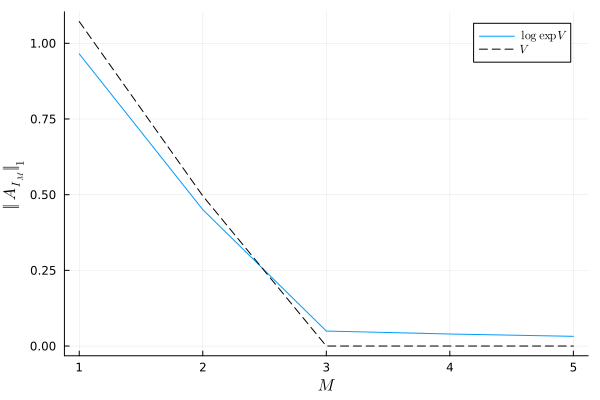

In [ ]:


t_dict = create_randomized_nth_order_operator(1, indexer; magnitude=2.0)
merge!(t_dict,create_randomized_nth_order_operator(2, indexer; magnitude=2.0))
# merge!(t_dict,create_randomized_nth_order_operator(3, indexer; magnitude=2.0))
rows = Int[]
cols = Int[]
vals = Float64[]
general_n_body!(rows, cols, vals, t_dict, indexer)

mat = Matrix(Hermitian(sparse(rows, cols, vals)))


pl = plot(xlabel=L"M", ylabel=L"\Vert A_{I_M}\Vert_1", legend=:topright)
# for (k,u) in enumerate([t_values ; U_values])
for (k,u) in enumerate(U_values[1:2])
    if k == reference_index
        hopping = mat
        # continue
        # new_U ,_ = qr(rand(size(degen_rm_U[1]*degen_rm_U[1]')...))
        # # println(new_U)
        # hopping = log(Matrix(new_U))
    else
        # hopping = log(MP(Random.shuffle(1:size(degen_rm_U[1],1)))*degen_rm_U[1]')
        hopping = log(exp(mat))
    end

    total = Dict()
    for (order, creation_annihiation) in difference_dict
        for index_list in values(creation_annihiation)
            for (i,j) in index_list
                # if abs(hopping[i,j]) > 0
                    if !(order in keys(total))
                        total[order] = [hopping[i,j]]
                    else
                        push!(total[order],hopping[i,j])
                    end
                # end
            end
        end
    end
    orders = sort(collect(keys(total)))
    average_coef = [mean(abs.(total[o])) for o in orders]
    # std_coef = [std(total[o])/sqrt(length(total[o])) for o in orders]
    if k == reference_index
        plot!(pl, orders, average_coef, label=L"V", linestyle=:dash, color=:black,xticks=orders)
    else
        plot!(pl, orders, average_coef,label=L"\log \exp V",xticks=orders)
    end
end
# plot!(pl,  ylims=(0,Inf),)
# savefig(pl,"order_images\\average_coeff_2x3_N=3.png")
# display(pl)
display(pl)
# savefig(pl, "order_images/explog_testing_N=6.png")

0.9772727272727273 of 924, 21


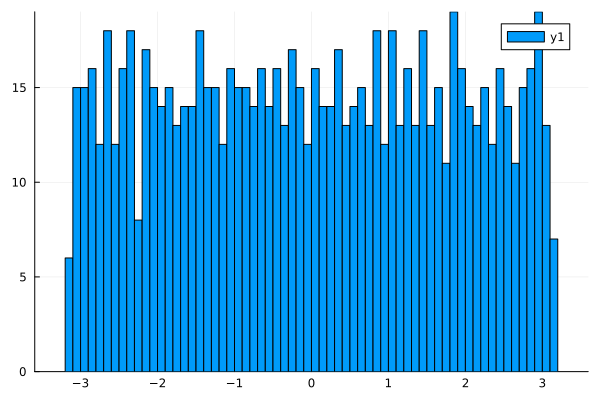

In [7]:
t_dict = create_randomized_nth_order_operator(1, indexer; magnitude=2.0)
merge!(t_dict,create_randomized_nth_order_operator(2, indexer; magnitude=2.0))
# t_dict3 = create_randomized_nth_order_operator(3, indexer; magnitude=0.5)
rows = Int[]
cols = Int[]
vals = Float64[]
general_n_body!(rows, cols, vals, t_dict, indexer)
mat = Matrix(Hermitian(sparse(rows, cols, vals)))
λ = eigvals(mat)

println("$(sum((λ .- minimum(λ) .> 2π)/length(λ))) of $(length(λ)), $(length(λ)-sum((λ .- minimum(λ) .> 2π)))")
histogram(angle.(eigvals(exp(1im*mat))), bins=100)

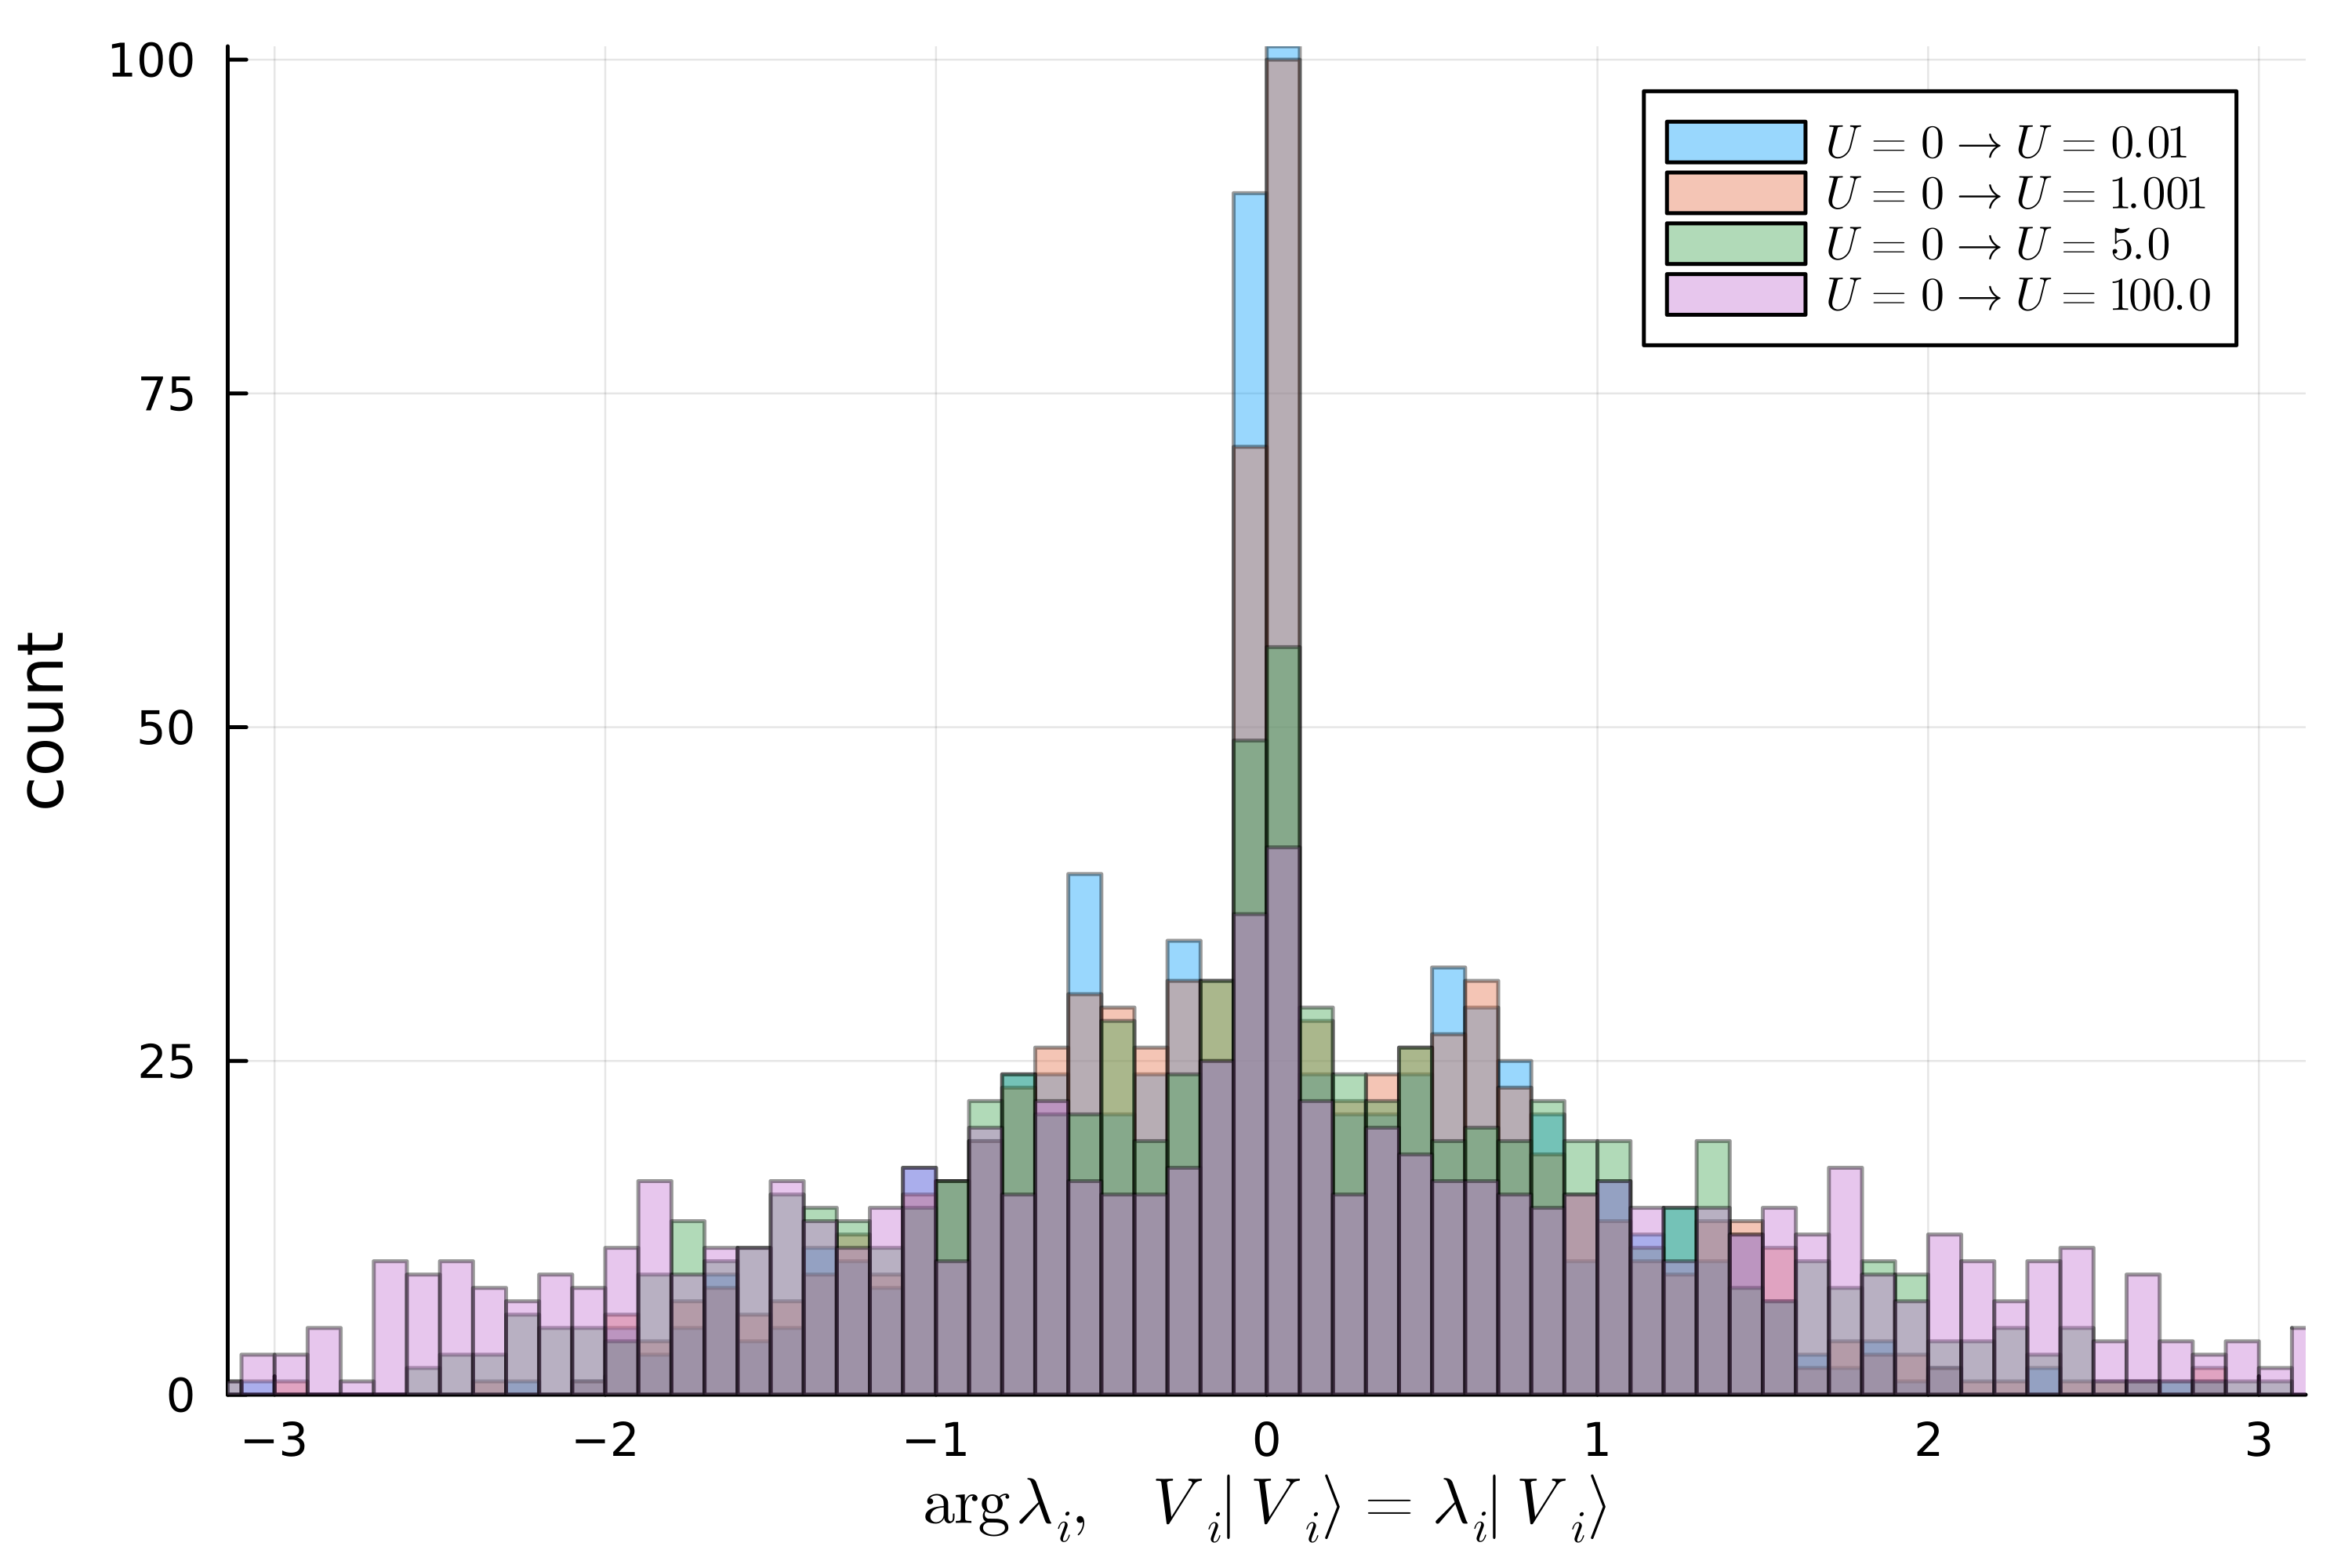

In [101]:
p = plot(xlims=[-π,π], xlabel=L"\arg \lambda_i, \quad V_i|V_i\rangle=\lambda_i |V_i\rangle", ylabel="count", dpi=500)
for i in 2:3:11
    histogram!(p, angle.(eigvals(degen_rm_U[1]*degen_rm_U[i]')), bins=100, alpha=0.4, label=L"U=0\rightarrow U=%$(U_values[i])")
end
savefig(p, "order_images/unitary_eigenvalues.png")
display(p)

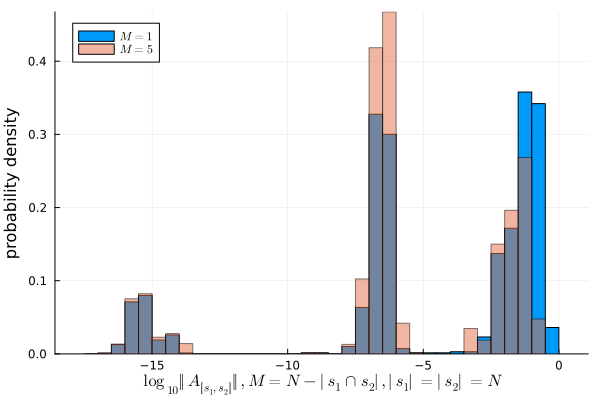

In [18]:
histogram(log10.(abs.(total[1])), normalize=:pdf, label=L"M=1")
histogram!(log10.(abs.(total[5])), normalize=:pdf, alpha=0.5, label=L"M=5", xlabel=L"\log_{10} \Vert A_{[s_1,s_2]}\Vert, M=N-|s_1\cap s_2|, |s_1|=|s_2|=N", ylabel="probability density")
# mean(abs.(filter(x-> -0.05<x<0.05,total[5]))), mean(abs.(filter(x-> -0.05<x<0.05,total[1])))

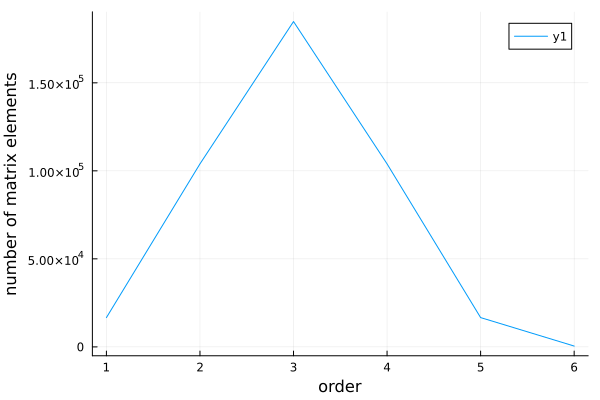

In [7]:
plot(1:maximum(collect(keys(total))), [length(total[i]) for i in 1:maximum(collect(keys(total)))], xlabel="order", ylabel="number of matrix elements")

In [ ]:
using DataStructures

h_tmp = copy(h1)
E,V = eigen(Matrix(op3))
println(counter(round.(angle.(E)/(2*pi)*360)))
h_tmp = real.(filter_matrix_by_vector(V'*h_tmp*V, E, 1))
E,V = eigen(h_tmp)
degeneracy_count(E)
# counter(round.(E*100))

Accumulator(0.0 => 39, 60.0 => 36, 180.0 => 36, 120.0 => 39, -60.0 => 36, -120.0 => 39)


Dict{Any, Any} with 3 entries:
  7 => 1
  2 => 7
  3 => 1

In [ ]:
# full_U1'*H[4]*full_U1
# sum(abs.(sort(real.(diag(full_U2'*H[4]*full_U2))) -E[4]))
full_U2*full_U1'

495×495 Matrix{ComplexF64}:
          1.0-1.93175e-18im  …   6.93889e-17-4.85723e-17im
  1.45901e-33-1.23472e-33im      7.34019e-33+2.30271e-33im
  2.88182e-18+1.25757e-17im      9.84294e-18+1.32359e-17im
  3.63069e-18+1.20987e-17im     -1.36022e-18+9.90441e-18im
 -6.29139e-34+4.93154e-33im     -1.12015e-32+5.3105e-33im
 -5.55112e-17-5.89806e-17im  …   1.11022e-16+6.93889e-18im
  4.93783e-33-6.88667e-35im      5.54204e-34+1.5287e-33im
  4.84921e-18+1.77883e-17im     -4.32814e-20+6.6255e-18im
  3.80748e-33-4.83374e-33im     -6.52998e-35+9.66335e-34im
  2.03674e-18+3.86456e-18im       -8.118e-19-3.05619e-17im
  3.62985e-18+6.00811e-18im  …  -2.06328e-17+1.54889e-18im
  2.59344e-34+1.03036e-33im      4.40207e-34+7.17239e-33im
  1.32593e-17-1.32801e-18im      3.25845e-18-1.63791e-17im
             ⋮               ⋱  
     5.04e-18+2.23986e-17im      2.00081e-18-5.03927e-19im
   4.8447e-34+2.86742e-33im     -6.01351e-33-3.48061e-33im
 -1.38778e-16-8.32667e-17im  …   1.52656e-16+9.71445e-17i

Any[-0.5, 0.75, 0, 0]


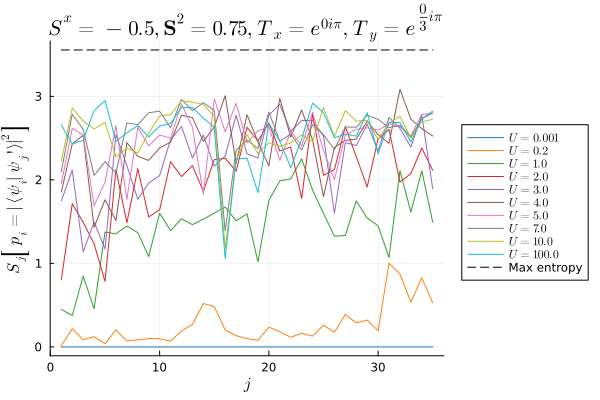

In [ ]:
i = 3
basis_transform, eigenvalues = filter_subspace([op1, op2, op4, op5], indices_of_interest[i])
_, V1, _ = schur(basis_transform'*H[1]*basis_transform)

eigenvalues[1:2] = round.(real.(eigenvalues[1:2]);digits=3)
eigenvalues[3:4] = angle.(eigenvalues[3:4])./pi
eigenvalues[4] *= 3
# eigenvalues[3] *= 2
eigenvalues[3:4] = Int.(round.(eigenvalues[3:4] ))
println(eigenvalues)
pl = plot(ylabel=L"S_j\left[p_i=|\langle \psi_i |\psi_j'\rangle|^2\right]", 
            xlabel=L"j",legend=:outerright, palette=:tab10,
            title=L"S^x=%$(eigenvalues[1]), \mathbf{S}^2=%$(eigenvalues[2]), T_x=e^{%$(eigenvalues[3]) i\pi }, T_y=e^{\frac{%$(eigenvalues[4])}{3} i\pi }")
for (u, h) in zip(U_values,H)
    _, V2, _ = schur(real.(basis_transform'*h*basis_transform))
    overlap = abs.(V1'*V2)
    p = abs.(overlap).^2
    entropy = ifelse.(p .> 0, -p .* log.(p), 0)
    # sum(entropy, dims=1)[1:7]
    # println(sqrt(tr((overlap-I)*(overlap-I)')))
    plot!(pl, collect(Iterators.flatten(sum(entropy, dims=1))),  label=L"U=%$(u)")
end
plot!(pl, [1, size(V1,1)], [log(size(V1,1)),log(size(V1,1))], label="Max entropy", linecolor=:black, linestyle=:dash)
savefig("images/entropy2x3_$(indices_of_interest[i])_N=$N.pdf")
display(pl)

In [ ]:
i = 3
basis_transform, eigenvalues = filter_subspace([op1, op2, op4, op5], indices_of_interest[i])
_, V1, _ = schur(real.(basis_transform'*H[1]*basis_transform))
_, V2, _ = schur(real.(basis_transform'*H[2]*basis_transform))
# sum(abs2.(basis_transform*V1*basis_transform')[1,:])
sum(abs2.(V1[1,:]))

0.9999999999999996

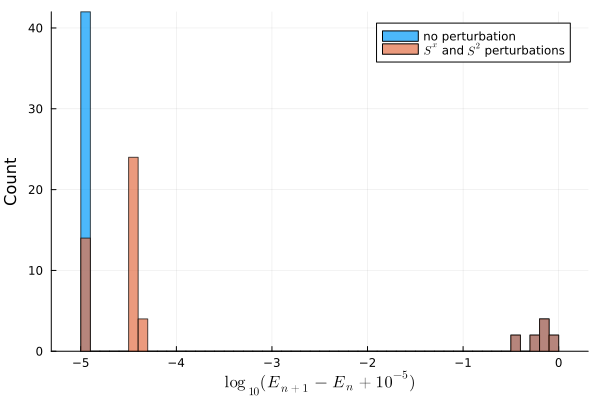

In [17]:
using StatsBase
epsilon = 1e-5

histogram(log10.(diff(real.(E[1])).+1e-5),bins=-5:0.1:0, label="no perturbation", ylabel="Count", xlabel=L"\log_{10}(E_{n+1}-E_{n}+10^{-5})",alpha=0.7)
histogram!(log10.(diff(real.(E[2])).+1e-5),bins=-5:0.1:0, label=L"$S^x$ and $S^2$ perturbations",alpha=0.7)
# plot!([0,250],[epsilon, epsilon],color="black")
# plot!(diff(E2))
# savefig("3x3_N=5_perturbation_effect.pdf")

In [ ]:
s1 = Set(findall(x-> (x<1e-6), diff(E1)))
s2 = Set(findall(x-> (x<1e-6), diff(E2)))
println(length(setdiff(union(s1,s2),symdiff(s1, s2))) - min(length(s2), length(s1)))

setdiff(s1, s2)

-4


Set{Int64} with 4 elements:
  484
  627
  505
  620

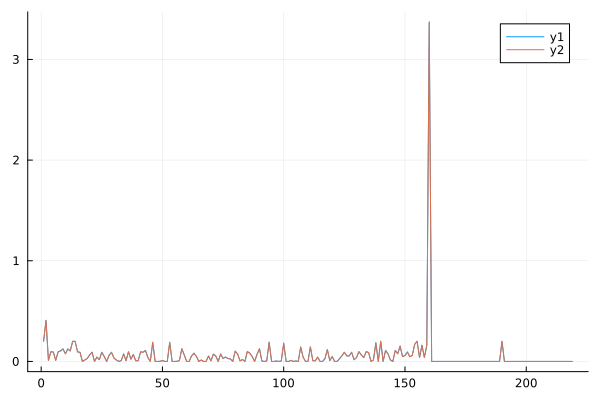

In [13]:
plot(abs.(diff(diag(V1'*H2*V1))))
plot!(abs.(diff(diag(V2'*H2*V2))))

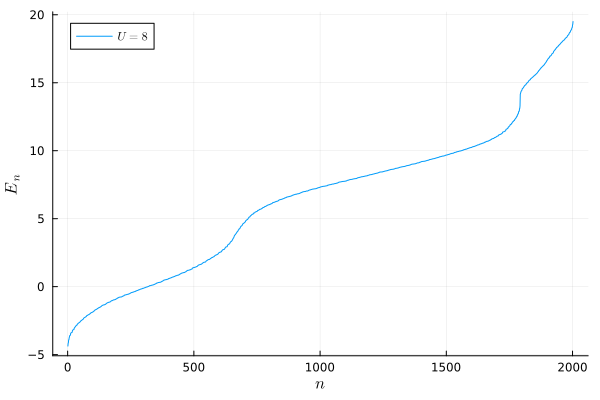

In [241]:
plot(E1, label=L"U=8", xlabel=L"n", ylabel=L"E_n")
# plot!(E2, label=L"U=16")
# plot!(E3, label=L"U=4")
# plot!(E5, label=L"U=7")
# plot!(E1,label=L"U=8")
# plot!(E6, label=L"U=10")
# savefig("3x3_mu=0_N=5.pdf")

In [43]:
U = V1'*V2 # energy basis
# sum(abs.(V1*U - V2))

p = abs.(U).^2
entropy = ifelse.(p .> 0, -p .* log.(p), 0)
# sum(entropy, dims=1)[1:7]
println(sqrt(tr((U-I)*(U-I)')))
sort(collect(Iterators.flatten(sum(entropy, dims=1))))

21.164111439747483


220-element Vector{Real}:
 -1.3322676294594337e-15
 -1.3322675877401919e-15
 -8.881784196489471e-16
 -8.881784152110461e-16
 -8.881783946470448e-16
 -8.881783728964097e-16
 -8.881781775751524e-16
 -4.4408920984410603e-16
 -4.4408920984340616e-16
 -4.440892094559743e-16
 -4.4408920901550995e-16
 -4.4408920843433108e-16
 -4.440892017035139e-16
  ⋮
  2.112446709904766
  2.117842350510945
  2.1233866932571486
  2.131917590078454
  2.1538853908616704
  2.1563823776925948
  2.183380225527846
  2.215692199846435
  2.315467625742235
  2.315467625745109
  2.350202161265325
  2.350202161265331

In [26]:
U = V2*V1' # computational basis 

# this unitary makes more sense to compute the quantum complexity of
p = abs.(U).^2
entropy = ifelse.(p .> 0, -p .* log.(p), 0)
sum(entropy, dims=1)[1:7]

7-element Vector{Float64}:
 4.67502010839971
 4.680287262859502
 4.659354108209212
 4.424107517776376
 4.6178977430646215
 4.729190837543825
 4.55988444900022

In [203]:
sort(diag(U))

56-element Vector{Float64}:
 -0.3622350403989767
 -0.2992150624609179
 -0.28993672285175137
 -0.21152239006569346
 -0.18832856913509408
 -0.1797076847870786
 -0.16965019734967052
 -0.16877421666506393
 -0.14366475399341608
 -0.13935394727038908
  ⋮
  0.10492454137675775
  0.12499828731651998
  0.12499915911691023
  0.2006406396609804
  0.20268272751856967
  0.24772500474752243
  0.3003698974614383
  0.3727207820225861
  0.420179608426703

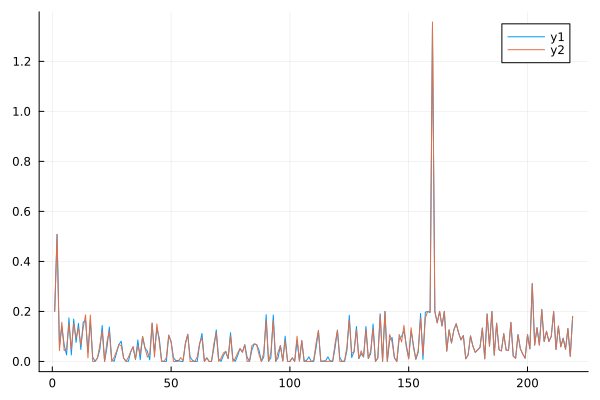

In [58]:
using Plots
plot(diff(E1))
plot!(diff(E2))

In [176]:
cicj = [dot(V2[:,3], cicj_array2[i,j,k]*V2[:,3]) for i=1:4, j=1:4, k=1:2]
for i=1:4
    println(cicj[i,i,1] + cicj[i,i,2])
end

0.749277920394003
0.7507255718773945
0.7507221048571685
0.7492744028714353


# Heisenberg 

In [5]:
N=2
lattice = Graphs.grid((2,2))
# lattice = Graphs.cycle_graph(3)

subspace = HubbardSubspace(N, lattice)
# subspace = HubbardSubspace(N_up, N_down, lattice)
h,indexer = create_Heisenberg(1.0, 0.5, subspace)

E,V = eigen(Matrix(h))
println(E)
psi0 = maximum(V[:,1])
for (i, psi) in enumerate(V[:,1])
    if abs.(psi) > 1e-8
        println(psi, " ", combination(indexer, i))
    end
end

[-3.22817805262833, -1.8789024427351722, -1.8789024427351722, -1.8789024427351713, -1.8789024427351713, -1.8789024427351713, -1.8789024427351642, -0.7500000000000022, -0.7499999999999953, -0.7499999999999949, 0.0, 0.0, 5.204170427930421e-17, 5.174920444975781e-16, 2.7555905900771413e-15, 0.25000000000000067, 0.2500000000000009, 0.2500000000000018, 0.2500000000000018, 0.250000000000002, 0.250000000000002, 2.1289024427351744, 2.1289024427351744, 2.128902442735175, 2.128902442735175, 2.128902442735175, 2.1289024427351753, 2.4781780526283317]
-0.2659220264360266 (Set([1]), Set([2]))
-0.2659220264360278 (Set([1]), Set([3]))
0.3295010648121068 (Set([1]), Set([4]))
0.26592202643602886 (Set([2]), Set([1]))
0.3295010648121091 (Set([2]), Set([3]))
-0.26592202643602775 (Set([2]), Set([4]))
0.2659220264360277 (Set([3]), Set([1]))
-0.32950106481210656 (Set([3]), Set([2]))
-0.2659220264360278 (Set([3]), Set([4]))
-0.32950106481210883 (Set([4]), Set([1]))
0.2659220264360276 (Set([4]), Set([2]))
0.265

# test

In [ ]:
# this attempt to see if there are any unitary transforms that 
# map the hubbard model to a density-density interaction model. The
# answer seems to be no, since only a unitary that commutes with the 
# Hamiltonian satisfies the constraint.
using LinearAlgebra
N = 5
Vp = rand(N,N)
tp = rand(N,N)
coefficients = zeros(N^3,2N^2)
convert_to_index(i,j) = (i-1)*N + j
convert_to_index(i,j,k) = (i-1)*N^2 + (j-1)*N + k
for (i,j,k) in Iterators.product(1:N, 1:N, 1:N)
    index = convert_to_index(i,j,k)
    coefficients[index, convert_to_index(k,i)] += Vp[i,j]-Vp[k,j]
    coefficients[index, convert_to_index(k,j)] += Vp[j,i]
    coefficients[index, convert_to_index(j,i)] += -Vp[j,k]

    coefficients[index, convert_to_index(i,j) + N^2] += -tp[k,i]
    coefficients[index, convert_to_index(j,i) + N^2] += -tp[k,j]
    coefficients[index, convert_to_index(k,j) + N^2] += tp[k,i]
    coefficients[index, convert_to_index(j,k) + N^2] += tp[j,i]
end
nullspace(coefficients)

50×1 Matrix{Float64}:
 0.16494158780944476
 0.1449519372457409
 0.04135351413576674
 0.16859104363942065
 0.20375454521249475
 0.1755925757934566
 0.14674946556946833
 0.07662602714201561
 0.14911511546543396
 0.20071850747242637
 0.12466895442338624
 0.22168736618288148
 0.02099487050589935
 ⋮
 0.04733686495791092
 0.022925758425951594
 0.12920987252455568
 0.22695664577273458
 0.10615683408636473
 0.19385937487464444
 0.065012283584813
 0.0075372541325304885
 0.17501632989589408
 0.07496970961599618
 0.15781500659950892
 0.10171354317531481

# Optimization

In [ ]:
include("ed_optimization.jl")
meta_data = Dict("electron count"=>4, "sites"=>"2x3", "bc"=>"periodic", "basis"=>"adiabatic", 
                "U_values"=>U_values, "maxiters"=>100)
instructions = Dict("starting state"=>Dict("U index"=>1, "levels"=>54),
                "ending state"=>Dict("U index"=>5, "levels"=>54), "max_order"=>2)
data_dict_tmp = test_map_to_state(degen_rm_U, instructions, indexer; maxiters=meta_data["maxiters"], optimization=:nonlinear)
data_dict_tmp["meta_data"] = meta_data
# append_to_json_files(data_dict_tmp, "data/slater_determinant_unitary_N=4")

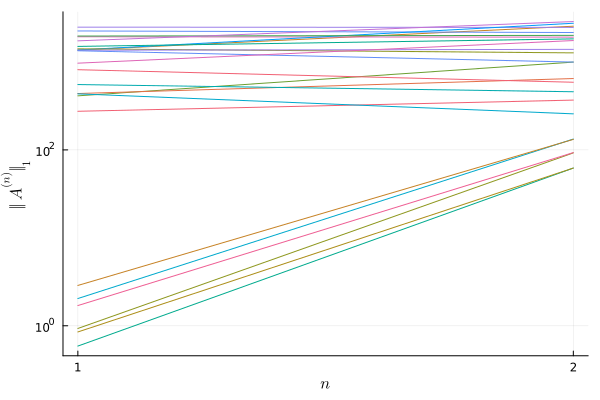

1 0
2 0
3 0
4 0
5 0
6 0
7 0
8 2547.938233483414
9 62.1865928818649
10 92.49659308138926
11 132.80552474292804
12 2469.446583768928
13 2160.087044480898
14 368.2123238087485
15 1913.8894464356865
16 996.3851647839339
17 2753.425691833072
18 647.3708570074032
19 2004.441753512793
20 2878.566315601931
21 62.140866030109315
22 458.12702971889166
23 93.17735430484245
24 131.73347469656545
25 1828.1676825484676
26 1267.8827387981394
27 256.90313574312245
28 1389.8148112490262
29 996.4316556002038
30 587.6202179703545
31 1750.4550497855212
32 0
33 0
34 0
35 0
36 0
37 0
38 0
39 0
40 0


In [14]:
data_dict3 = load_json_folder("single_particle_equal_state_unitary_tests")
p = plot(legend=false, xlabel=L"n",yscale=:log10,ylabel=L"\Vert A^{(n)}\Vert_1", xticks=[0,1,2])
for (label, v) in zip(data_dict3["labels"], data_dict3["norm1_metrics"])
    if length(v) >= 2
        println("$(label["starting state"]["level"]) $(v[2])")
    else
        println("$(label["starting state"]["level"]) 0")
    end
    plot!(p, [1,2][1:length(v)], v)
end
savefig(p, "single_state_map_images/norm1.png")
display(p)


10.0
10.0


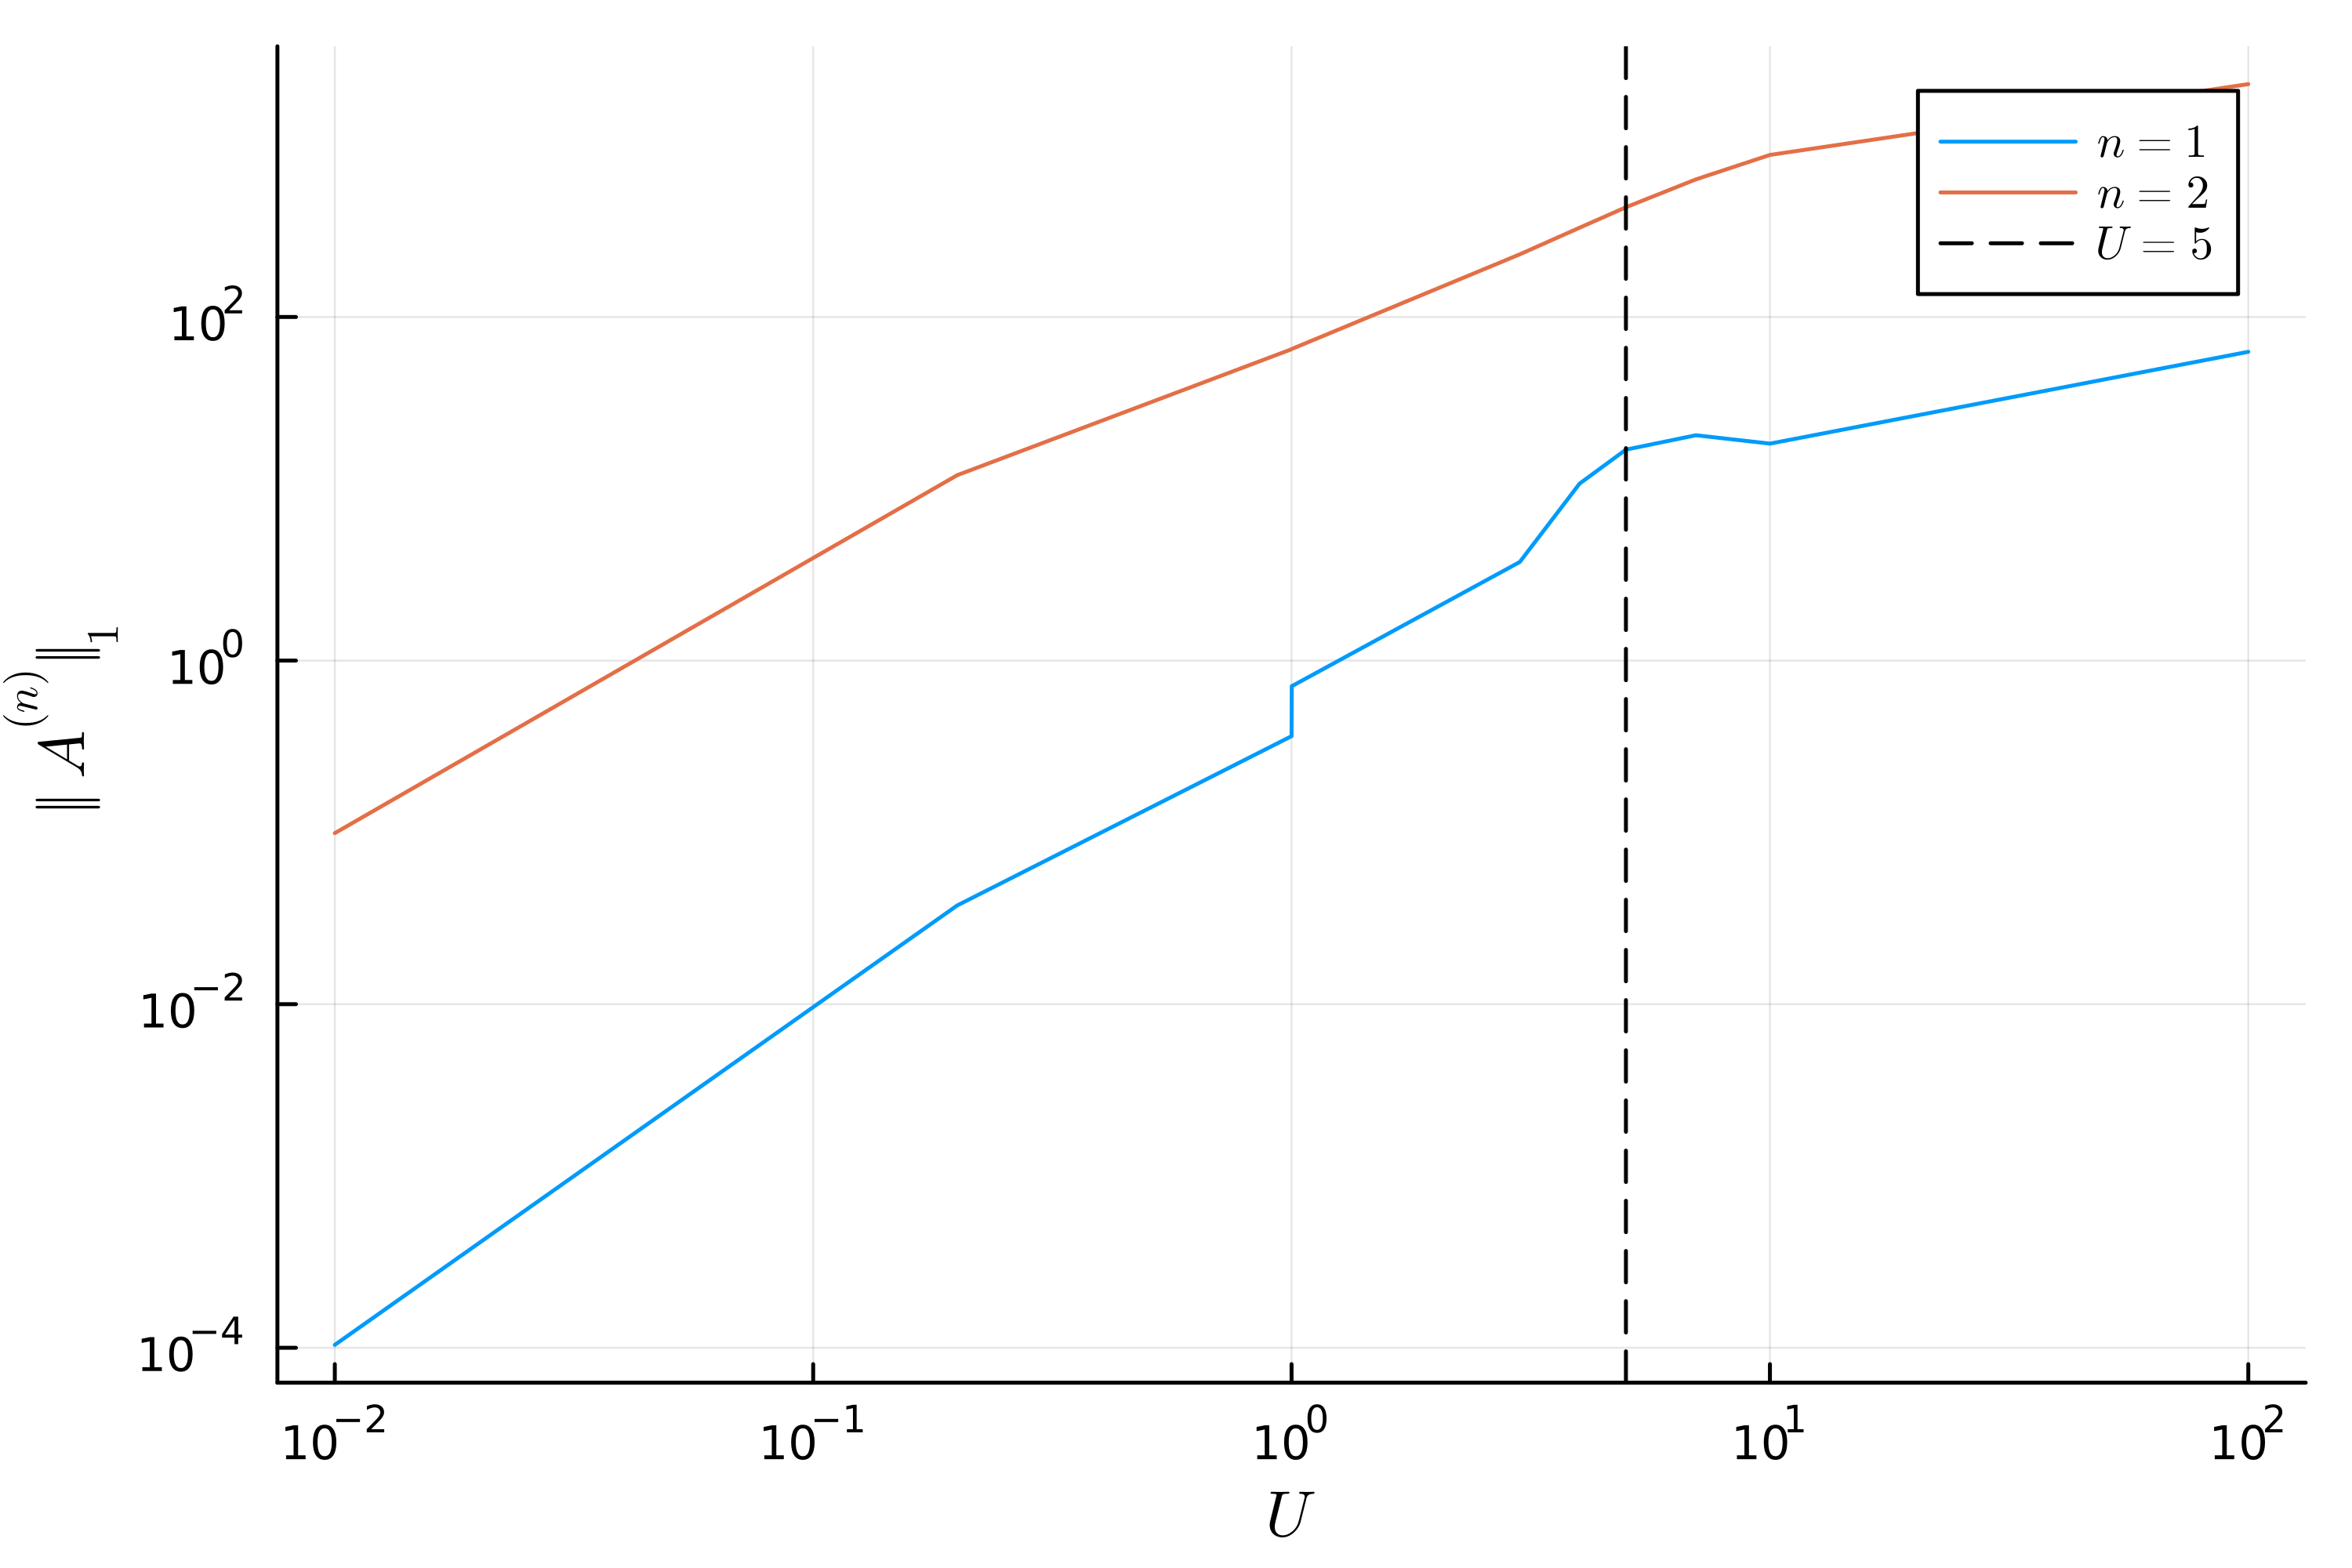

In [95]:
using Glob
target_starting_level = 58
target_ending_level = 58
p = plot(xlabel=L"U",yscale=:log10, xscale=:log10, ylabel=L"\Vert A^{(n)}\Vert_1",dpi=500)
for i = 1:2
    y = []
    x = []
    for path in readdir(glob"single_particle_equal_state_interaction_unitary_tests*", "data")
        data_dict3 = load_json_folder(path)
        for (label, v) in zip(data_dict3["labels"], data_dict3["norm1_metrics"])
            if (length(v) < 2 || label["starting state"]["level"] != target_starting_level ||
                 label["ending state"]["level"] != target_ending_level)
                continue
            end
            push!(y, v[i])
            push!(x, data_dict3["meta_data"]["U_values"][label["ending state"]["U index"]])
            # if length(v) >= 2
            #     println("$(label["starting state"]["level"]) $(v[2])")
            # else
            #     println("$(label["starting state"]["level"]) 0")
            # end
        end
    end
    j = sortperm(x)
    peak_i = argmax(diff(y[j]))
    println(x[j][peak_i])
    plot!(p, x[j], y[j], label=L"n=%$i")
end
vline!(p,[5], c="black", linestyle=:dash, label=L"U=5")
savefig(p, "single_state_map_images/norm1_level58_U_values.png")
display(p)


In [ ]:
data_dict3 = load_json_folder("data/single_particle_equal_state_interaction_unitary_tests")
p = plot(legend=false, xlabel=L"n",yscale=:log10,ylabel=L"\Vert A^{(n)}\Vert_1", xticks=[0,1,2])
for (label, v) in zip(data_dict3["labels"], data_dict3["norm1_metrics"])
    if length(v) >= 2
        println("$(label["starting state"]["level"]) $(v[2])")
    else
        println("$(label["starting state"]["level"]) 0")
    end
    plot!(p, [1,2][1:length(v)], v)
end
savefig(p, "single_state_map_images/norm1.png")
display(p)


In [65]:
for i in 10#2:length(U_values)
    meta_data = Dict{String, Any}("electron count"=>3, "sites"=>"2x3", "bc"=>"periodic", "basis"=>"adiabatic", 
                    "U_values"=>U_values, "maxiters"=>100)
    instructions = Dict{String, Any}("starting state"=>Dict("U index"=>1, "levels"=>32),
                    "ending state"=>Dict("U index"=>i, "levels"=>33))
    data_dict_tmp3 = test_map_to_state(degen_rm_U, instructions, indexer; maxiters=meta_data["maxiters"])
    data_dict_tmp3["meta_data"] = meta_data
    # append_to_json_files(data_dict_tmp3, "data/single_particle_equal_state_interaction_unitary_tests")
end

magnitude: 0.5
learning rate: 0.1
  0.000061 seconds (807 allocations: 47.812 KiB)
  0.025682 seconds (472.61 k allocations: 54.476 MiB)
0.9996867305801277
0.9705235913646102
0.8436247174891316
0.6165414549179036
0.36117698840825274
0.2000562528027734
0.1512013987555374
0.1548528994500895
0.162384453459397
0.1624276264908885
0.14938225543502404
0.12387124266438987
0.09793070263614012
0.08465402842469738
0.08575481069513591
0.08813979125742655
0.07818737048566704
0.05663678821924922
0.03668534434665305
0.030384618714906497
0.036163592580815807
0.042913551012566775
0.0436997975983453
0.03889319455951723
0.03168155541315221
0.02493533556835581
0.02043887950660095
0.018677699965252592
0.01849895694351633
0.017816762102105588
0.015391214588202695
0.01217076390933558
0.010456056389215873
0.011010961573183042
0.012156657519187042
0.011899440525530824
0.009851743198530327
0.007113627505782927
0.0051392785475865566
0.0046603739369751596
0.005217730206039772
0.005691612856376316
0.00540486866569

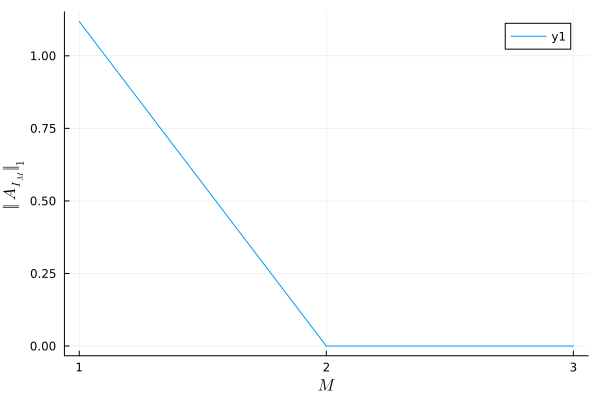

In [ ]:
vals = update_values(signs, ops_list, Dict(zip(t_keys,t_vals)))
mat = exp(1im*Matrix(Hermitian(sparse(rows, cols, vals, dim, dim)))/100)
# second_quantized_solution, second_quantized_nullspace, second_quantized_order_labels = find_N_body_interactions(mat, indexer)

pl = plot(xlabel=L"M", ylabel=L"\Vert A_{I_M}\Vert_1", legend=:topright)
# for (k,u) in enumerate([t_values ; U_values])
hopping = log(mat)*100
total = Dict()
for (order, creation_annihiation) in difference_dict
    for index_list in values(creation_annihiation)
        for (i,j) in index_list
            # if abs(hopping[i,j]) > 0
                if !(order in keys(total))
                    total[order] = [hopping[i,j]]
                else
                    push!(total[order],hopping[i,j])
                end
            # end
        end
    end
end
orders = sort(collect(keys(total)))
average_coef = [mean(abs.(total[o])) for o in orders]
# std_coef = [std(total[o])/sqrt(length(total[o])) for o in orders]

plot!(pl, orders, average_coef,xticks=orders)


# plot!(pl,  ylims=(0,Inf),)
# savefig(pl,"order_images\\average_coeff_2x3_N=3.png")
display(pl)

In [68]:
include("ed_optimization.jl")
for i in 10:10
    # meta_data = Dict{String, Any}("electron count"=>3, "sites"=>"2x3", "bc"=>"periodic", "basis"=>"adiabatic", 
    #                 "U_values"=>U_values, "maxiters"=>100, "method"=>"sd sum")
    # instructions = Dict{String, Any}("goal state"=>Dict("U index"=>i, "levels"=>8))
    starting_state = zeros(dim)
    starting_state[2] = 1.0
    data_dict_tmp3 = optimize_sd_sum_2(starting_state, indexer,1;maxiters=200)
    # data_dict_tmp3["meta_data"] = meta_data
#     append_to_json_files(data_dict_tmp3, "data/single_particle_equal_state_interaction_sd_sum_tests")
end


0.8207685045562368
0.4302967278749157
0.14825363792824697
0.1510897385849087
0.2377963626458368
0.2671917641444951
0.24112262013236563
0.19577839604438552
0.16117050864477778
0.14592755530848078
0.1421354657510392
0.13797920017138465
0.12673417665992415
0.10875859795649134
0.08842816624006244
0.07024793627588843
0.056761735629843435
0.048419213217041124
0.0443500824937042
0.04314391093337244
0.04335234998388304
0.0437770670994867
0.043632725636550296
0.0426023244171474
0.04077490386004945
0.03848995922204146
0.03615479722086967
0.03410243158920612
0.032521151546430316
0.03144759575697453
0.03079754054432815
0.030411354606988295
0.030100760560557327
0.029690406004412973
0.029049955501100122
0.028112787774607795
0.026878979742710585
0.02540381415253501
0.023776908813100683
0.022099001226594694
0.020462536337294557
0.018939395856381935
0.017576071786801206
0.016394578320921283
0.015396725102148179
0.014569666139302662
0.013891332474553097
0.013335038940497257
0.012873039737350878
0.012479

In [70]:
starting_state = zeros(dim)
starting_state[2] = 1.0
computed_matrices, coefficients, loss = optimize_sd_sum_2(starting_state, indexer,1;maxiters=200)

0.9377559323970279
0.6532291827906542
0.3019805433602393
0.13318144583985703
0.16687086569122123
0.23609794211758883
0.2618412232769953
0.24594284073268458
0.20727155693877275
0.1630939386134601
0.1241338700755813
0.09591294268927264
0.0797628640420821
0.07392276749840354
0.07509776477970265
0.07983601073500624
0.085339223439173
0.0897191349117481
0.09189662183139335
0.09140371239105471
0.08826694395944834
0.08297950483073058
0.07643116480944556
0.06968714928471065
0.0636761585350818
0.05895293160342485
0.05563351670515071
0.053479311656506545
0.052052649456459044
0.05087982744412445
0.04958274649774164
0.04795499250034796
0.04597194350615952
0.04374511002497372
0.0414493253419439
0.039254778202661766
0.03728383436022176
0.03559602004948159
0.034193582695889124
0.03303721353267153
0.03206381128304492
0.031201828203785587
0.030382663152218603
0.029548227661797544
0.028655435211712543
0.02767835051168932
0.026608456256298707
0.025453243747107557
0.024233284748840234
0.022978107649246682


(Any[[0.73762477731578 -0.5860293334090072 … 0.0 0.0; -0.5860293334090072 0.2478001005026979 … 0.0 0.0; … ; 0.0 0.0 … 2.7026372196726287 0.6368755866834475; 0.0 0.0 … 0.6368755866834475 3.595196015493905]], [0.999999999999998], 0.0023373362655072505)

In [81]:
t_dict = Dict{Vector{Tuple{Coordinate{2,Int64},Int,Symbol}}, Float64}()

t_dict[[(Coordinate(1, 2), 2,:create), (Coordinate(2, 2), 2, :annihilate)]] = 1
t_dict[[(Coordinate(2, 2), 2,:create), (Coordinate(1, 2), 2, :annihilate)]] = 1
rows = Int[]
cols = Int[]
vals = Float64[]
general_n_body!(rows, cols, vals, t_dict, indexer)

starting_state = zeros(dim)
starting_state[2] = 1.0
Matrix(Hermitian(sparse(rows, cols, vals, dim, dim)))*starting_state

220-element Vector{Float64}:
 -1.0
  0.0
  0.0
  0.0
  0.0
  0.0
  0.0
  0.0
  0.0
  0.0
  ⋮
  0.0
  0.0
  0.0
  0.0
  0.0
  0.0
  0.0
  0.0
  0.0

In [69]:
indexer.inv_comb_dict

220-element Vector{Tuple{Set{Coordinate{2, Int64}}, Set{Coordinate{2, Int64}}}}:
 (Set(), Set([Coordinate(1, 2), Coordinate(1, 1), Coordinate(2, 1)]))
 (Set(), Set([Coordinate(1, 1), Coordinate(2, 1), Coordinate(2, 2)]))
 (Set(), Set([Coordinate(1, 3), Coordinate(1, 1), Coordinate(2, 1)]))
 (Set(), Set([Coordinate(2, 3), Coordinate(1, 1), Coordinate(2, 1)]))
 (Set(), Set([Coordinate(1, 2), Coordinate(1, 1), Coordinate(2, 2)]))
 (Set(), Set([Coordinate(1, 3), Coordinate(1, 2), Coordinate(1, 1)]))
 (Set(), Set([Coordinate(2, 3), Coordinate(1, 2), Coordinate(1, 1)]))
 (Set(), Set([Coordinate(1, 3), Coordinate(1, 1), Coordinate(2, 2)]))
 (Set(), Set([Coordinate(2, 3), Coordinate(1, 1), Coordinate(2, 2)]))
 (Set(), Set([Coordinate(1, 3), Coordinate(2, 3), Coordinate(1, 1)]))
 ⋮
 (Set([Coordinate(1, 3), Coordinate(1, 2), Coordinate(2, 1)]), Set())
 (Set([Coordinate(2, 3), Coordinate(1, 2), Coordinate(2, 1)]), Set())
 (Set([Coordinate(1, 3), Coordinate(2, 1), Coordinate(2, 2)]), Set())
 (Set(